In [82]:
# Bayesian HW Set 3: Analytical Methods / Bayes Monte Carlo / Grid Methods
# February 2025

##  author: Alexis Hudes
##  copyright by the author
##  distributed under the GNU general public license
##  https://www.gnu.org/licenses/gpl.html
##  no warranty (see license details at the link above)

#Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde, t
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import random

#set seed
np.random.seed(42)

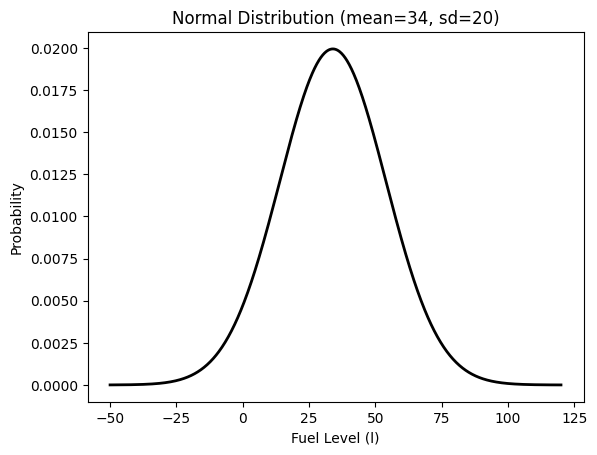

In [83]:
#Initial PDF

# x axis range
x = np.linspace(-50, 120, 1000)

# Plot a normal dist with mean=34 and sd=20
plt.plot(x, norm.pdf(x, loc=34, scale=20), label='Normal Distribution', color="black", lw=2)

# title, labels
plt.title('Normal Distribution (mean=34, sd=20)')
plt.xlabel('Fuel Level (l)')
plt.ylabel('Probability')

# Show the plot
plt.show()
plt.close()

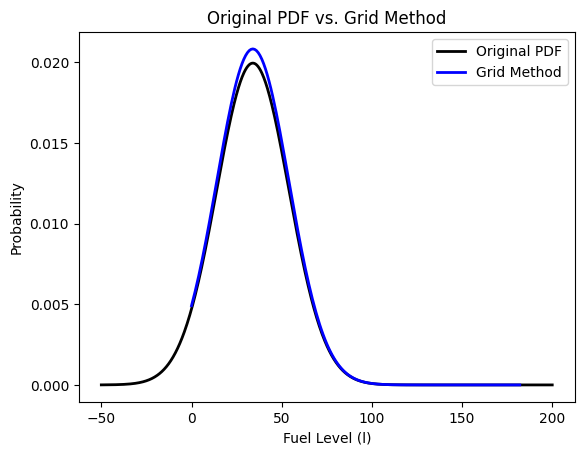

In [84]:
#Grid based method 
# Sample each integer from 0 to 182
samples_GBM = np.arange(0, 183, 1)

# Uniform prior from 0 to 182, all values will be 1/183
prior = 1 / 183

# Likelihood of the observed value if the sample is the actual value
likelihood_GBM = norm.pdf(34, samples_GBM, 20)

# The posterior is proportional to the prior * likelihood
posterior_GBM = prior * likelihood_GBM

# Normalize the posterior by dividing each probability by the sum of all of them
normalized_posterior_GBM = posterior_GBM / np.sum(posterior_GBM)

# Plotting the distribution compared to the original
x = np.linspace(-50, 200, 1000)
plt.plot(x, norm.pdf(x, loc=34, scale=20), label="Original PDF", color="black", lw=2)
plt.plot(samples_GBM, normalized_posterior_GBM, label="Grid Method", color="blue", lw=2)

# title, labels, legend
plt.title("Original PDF vs. Grid Method")
plt.xlabel("Fuel Level (l)")
plt.ylabel("Probability")
plt.legend(loc="upper right")

# Show the plot
plt.show()
plt.close()


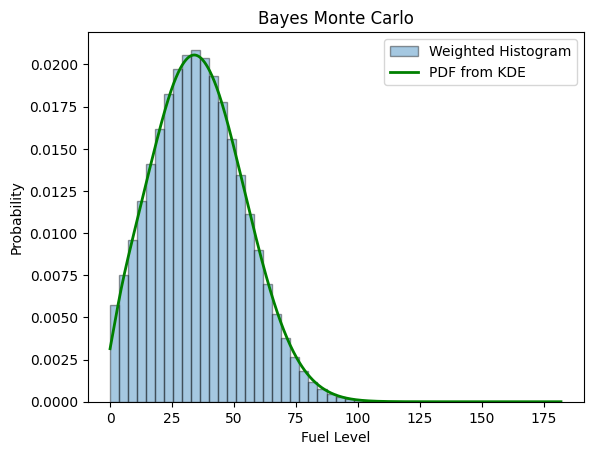

In [85]:
#Bayes Monte Carlo

# Number of samples
n = 3*10**6

# Sample from a uniform prior between 0 and 182
samples_BMC = np.random.uniform(low=0, high=182, size=n)

# likelihood for each sample based on the observed reading
likelihood_BMC = norm.pdf(samples_BMC, loc=34, scale=20)

# kernel density estimator
kde = gaussian_kde(samples_BMC, bw_method=0.2, weights=likelihood_BMC)

# list of KDE over a range of x values
x_kde = np.linspace(0, 182, 1000)
kde_pdf = kde(x_kde)

# Plot the histogram of the samples with the likelihood as weights
plt.hist(samples_BMC, bins=50, weights=likelihood_BMC, density=True, alpha=0.4, label="Weighted Histogram", edgecolor='black')

# Plot the KDE
plt.plot(x_kde, kde_pdf, label="PDF from KDE", color='green', lw=2)

#title, labels
plt.title('Bayes Monte Carlo')
plt.xlabel('Fuel Level')
plt.ylabel('Probability')

#show plot and legend
plt.legend()
plt.show()
plt.close()


In [86]:
# Testing for convergence

#Sample from the posterior
posterior_BMC = random.choices(samples_BMC, weights = likelihood_BMC, k = n)

# define the confidence interval convergence check, based on the example from workflow.r
def check_convergence(chain, threshold):
    # Compute the confidence interval of the mean
    ci = 2 * t.ppf(0.975, len(chain)) * np.std(chain) / np.sqrt(len(chain))
    print("The confidence interval is:", ci)

    # Check if the confidence interval is less than the threshold
    if ci <= threshold:
        return True
    else:
        return False

# Check convergence 
converged = check_convergence(posterior_BMC, threshold=0.05)

if converged:
    print("The chain has converged")
else:
    print("The chain has not converged")


The confidence interval is: 0.04106184002802912
The chain has converged


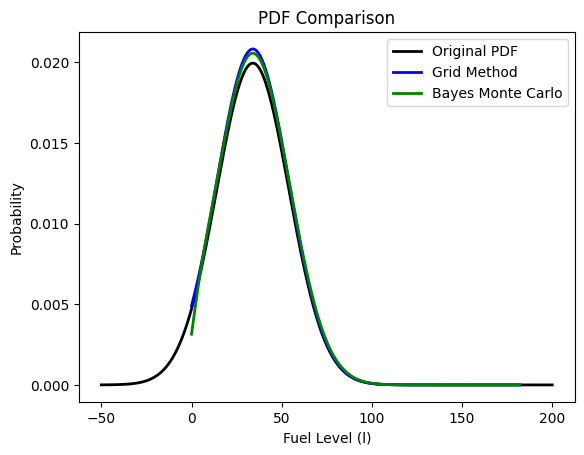

In [87]:
# Plotting the original, grid, and bayes pdfs all together

# original
x = np.linspace(-50, 200, 1000)
plt.plot(x, norm.pdf(x, loc=34, scale=20), label="Original PDF", color="black", lw=2)
# grid based
plt.plot(samples_GBM, normalized_posterior_GBM, label="Grid Method", color="blue", lw=2)
# Bayes
plt.plot(x_kde, kde_pdf, label="Bayes Monte Carlo", color='green', lw=2)

# title, labels, legend
plt.title("PDF Comparison")
plt.xlabel("Fuel Level (l)")
plt.ylabel("Probability")
plt.legend(loc="upper right")

# Show the plot
plt.show()
plt.close()

In [88]:
# Flight time calculations

# Start by getting the cdf from Bayes Monte Carlo fuel distribution

# Evaluate the PDF at each point in the range
x = np.linspace(0, 182, 1000)
pdf_values = kde(x)

# integrate the PDF to get the CDF
cdf_values = cumtrapz(pdf_values, x, initial=0)

# Normalize (want last value to be 1)
cdf_values /= cdf_values[-1]

# n samples from a uniform dist
n = 1000
uniform_random_numbers = np.random.uniform(0, 1, n)

# Interpolate the inverse CDF
inverse_cdf = interp1d(cdf_values, x, bounds_error=False, fill_value=(x[0], x[-1]))

# Generate fuel values from the distribution using the inverse CDF
fuel_values = inverse_cdf(uniform_random_numbers)

# generate fuel consumption values
consumption = np.random.normal(loc=18, scale=2, size=n)

#flight times in minutes
flight_time = 60*fuel_values/consumption

# kernel density estimator
flight_kde = gaussian_kde(flight_time,bw_method=0.4)

# list of KDE over a range of x values
x_kde = np.linspace(0, 400, 1000)
flight_pdf = flight_kde(x_kde)

# flight cdf
cdf_flight = cumtrapz(flight_pdf, x_kde, initial=0)

# Normalize
cdf_flight /= cdf_flight[-1]

# survival function
survival = 1 - cdf_flight

/var/folders/l8/64n1xkls34j0y9f69yddph840000gq/T/ipykernel_68236/2255922543.py:10: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf_values = cumtrapz(pdf_values, x, initial=0)
/var/folders/l8/64n1xkls34j0y9f69yddph840000gq/T/ipykernel_68236/2255922543.py:39: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf_flight = cumtrapz(flight_pdf, x_kde, initial=0)


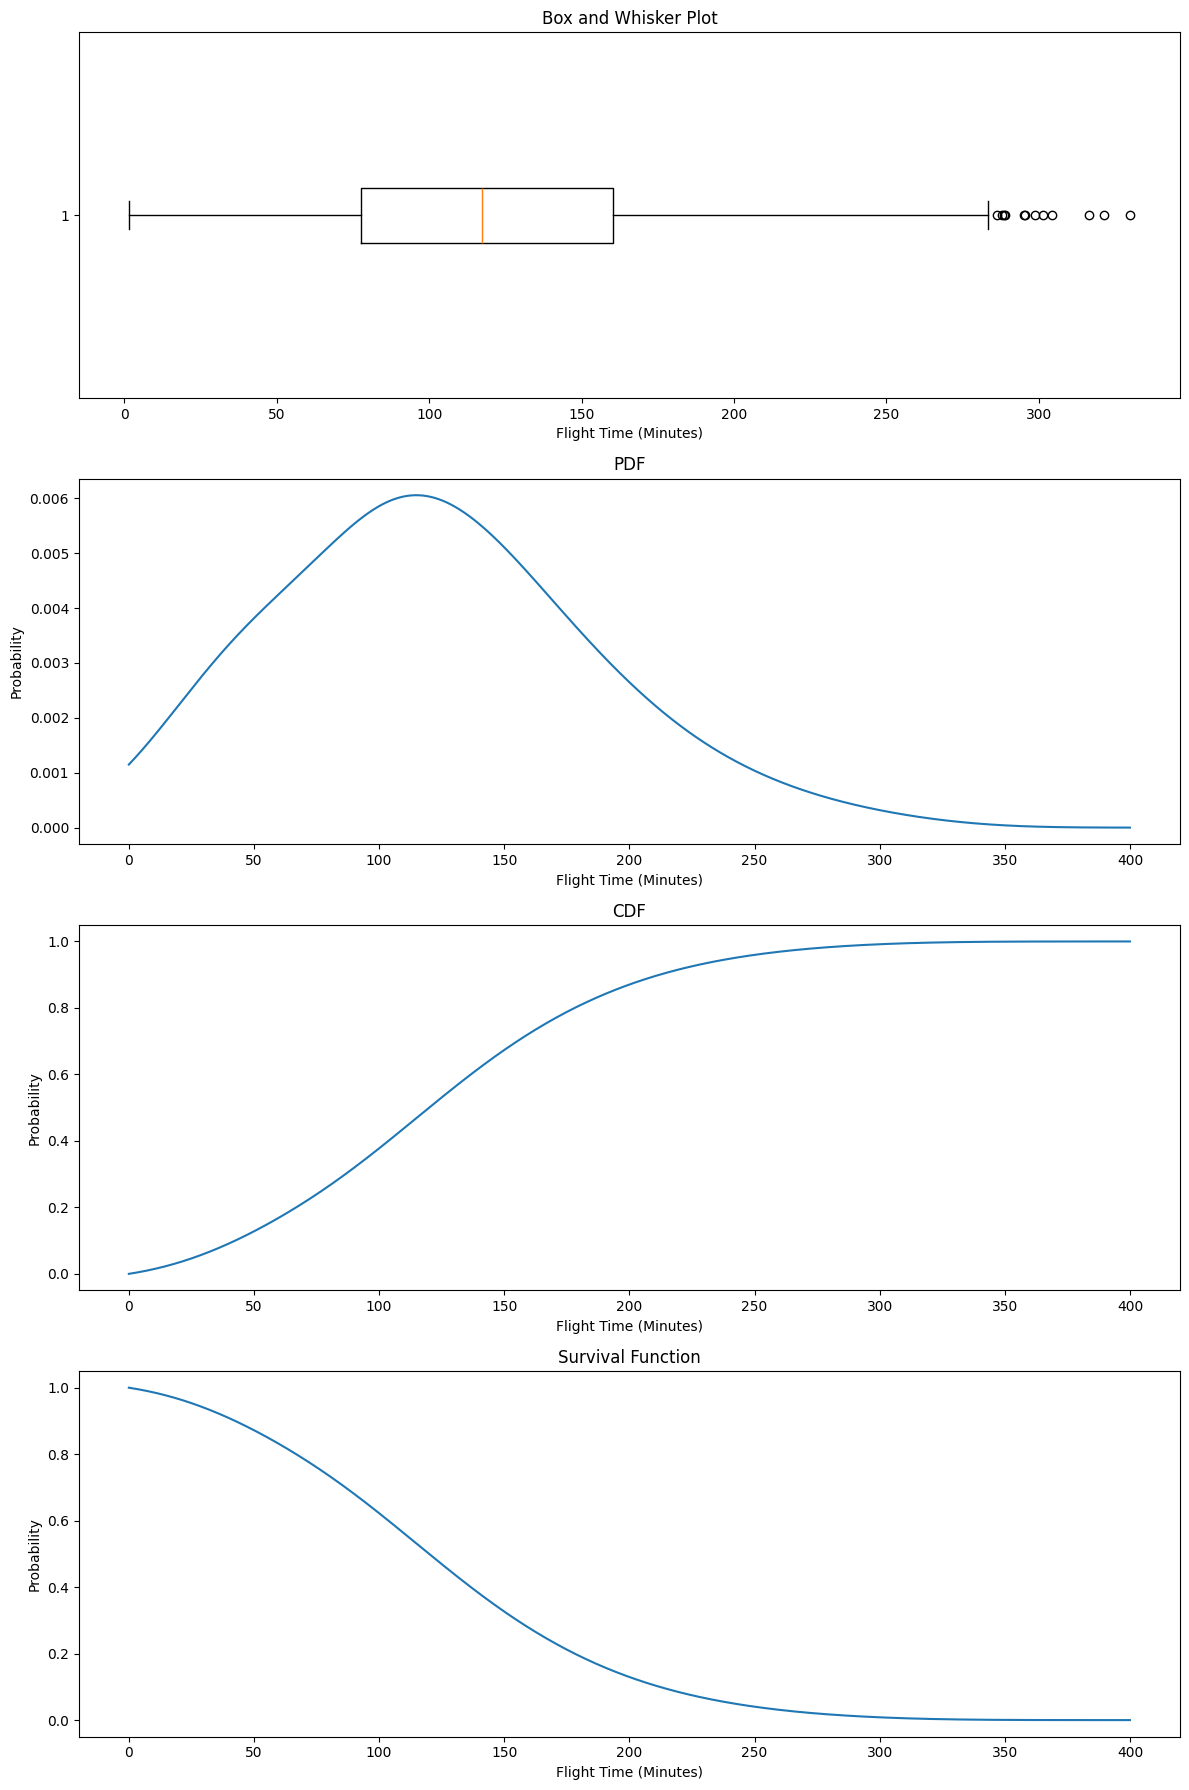

In [89]:
#Plotting all of the flight time stuff together
# Create subplots (4 rows, 1 col)
fig, axs = plt.subplots(4, 1, figsize=(12, 18))

# Box and whisker
axs[0].boxplot(flight_time, vert=False)
axs[0].set_title("Box and Whisker Plot")
axs[0].set_xlabel("Flight Time (Minutes)")

# PDF
axs[1].plot(x_kde, flight_pdf)
axs[1].set_title("PDF")
axs[1].set_xlabel("Flight Time (Minutes)")
axs[1].set_ylabel("Probability")

# CDF
axs[2].plot(x_kde, cdf_flight)
axs[2].set_title("CDF")
axs[2].set_xlabel("Flight Time (Minutes)")
axs[2].set_ylabel("Probability")

# Survival function
axs[3].plot(x_kde, survival)
axs[3].set_title("Survival Function")
axs[3].set_xlabel("Flight Time (Minutes)")
axs[3].set_ylabel("Probability")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [90]:
# getting probabilities for question 7

# probability of at least 130 min

# Get the closest index in x_kde to 130 minutes
index_130 = np.searchsorted(x_kde, 130)

# Get the value of the survival function at 100 minutes
survival_at_130 = survival[index_130]

print(f"Survival at 130 minutes: {survival_at_130}")


# probability less than 100 min

# Get the closest index in x_kde to 100 minutes
index_100 = np.searchsorted(x_kde, 100)

# Get the value of the cdf
cdf_at_100 = cdf_flight[index_100]

print(f"CDF at 100 minutes: {cdf_at_100}")

Survival at 130 minutes: 0.4383438928469756
CDF at 100 minutes: 0.37810477754077226
